# Beautiful numbers - ML

## Load libraries and data

In [1]:
# pandas + numpy
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

#sklearn
from sklearn.model_selection import train_test_split

import sys
# append the path of the parent directory
sys.path.append("..")
from lib.utils import *


/Users/almu/Code/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# prepare data
features = pd.read_csv('../data/nr_beauty_metrics.csv', dtype={'str_n':str})
target = pd.read_csv('../data/lottery_nr_sales.csv')

# Tune the parameters of the model to improve the R² (feature engineering)
features = features.drop(columns = ['is_odd', 'start_digit', 'n', 'str_n', 'leap_metric', 'odd_count', 'repeat_sum', 'has_repeated_digits','repeat_max', 'repeat_digit_count', 'dist_digits_count', 'ends_00', 'starts_00', 'is_prime', 'starts_15', 'ends_15'])

# get dummies 
features = pd.get_dummies(features, columns=['repeat_consec_max'], drop_first=True)

target = target['mean']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.30, random_state=42)


In [3]:
features.columns

Index(['contains_13', 'ends_0', 'ends_13', 'ends_5', 'ends_69', 'ends_7',
       'ends_prime', 'starts_0', 'starts_13', 'starts_9', 'is_date',
       'is_palindrome', 'is_series', 'is_postal_code', 'repeat_consec_max_2',
       'repeat_consec_max_3', 'repeat_consec_max_4', 'repeat_consec_max_5'],
      dtype='object')

## Compare Models

### Linear Regression

We will start by exploring a linear regression. 
This will tell us how the different features of our df impact the target, and if they are significative. 

In [4]:
df = pd.concat([features, target], axis=1)
all_columns = "+".join(features.columns)
res = smf.glm(formula="mean ~" + all_columns, data=df, family=sm.families.Binomial()).fit()
print(res.summary())

pred = res.predict(features)

# find the correlation between pred and target
print("R2: ", (np.corrcoef(pred, target)[1][0])**2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mean   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99981
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36151.
Date:                Thu, 24 Oct 2024   Deviance:                       8744.4
Time:                        22:48:41   Pearson chi2:                 8.37e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.07897
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [5]:
# Let's analyse the impact (Odds Ratio) of each feature on the predicted target.
params = res.params 
conf = res.conf_int() 
conf['Odds Ratio'] = params 
conf.columns = ['5%', '95%', 'Odds Ratio'] 
print(np.exp(conf))

                                    5%        95%  Odds Ratio
Intercept                     3.943896   4.169521    4.055140
contains_13[T.True]           1.014163   1.280914    1.139761
ends_0[T.True]                0.567732   0.624967    0.595662
ends_13[T.True]              15.452817  48.190123   27.288700
ends_5[T.True]                2.167975   2.453599    2.306370
ends_69[T.True]               2.835018   4.422908    3.541048
ends_7[T.True]                2.021842   2.285895    2.149818
ends_prime[T.True]            1.013461   1.099190    1.055456
starts_0[T.True]              0.348546   0.384454    0.366060
starts_13[T.True]             1.405710   2.080696    1.710221
starts_9[T.True]              0.570359   0.627739    0.598362
is_date[T.True]               1.150093   1.235198    1.191886
is_palindrome[T.True]         1.024607   1.423976    1.207898
is_series[T.True]             0.422838   8.649297    1.912395
is_postal_code[T.True]        1.092282   1.209522    1.149408
repeat_c

**Learnings**

After choosing the parameters to optimise the R2 value (feature engineering), it seems that most of the features produce a significant impact on the sales mean (p < 0.05>). 
Only repeat_consec_max_5 and is_series are less likely to be significant. This is probably because there are very few numbers that belong to these categories, but the effect of this params is quite considerable, so we'll leave them in the model for now. 

### ML models

In [10]:
compare_models(X_train, y_train, X_test, y_test)

Decision Tree
MAE 0.09003271556670121
RMSE 0.11834514161344861
R2 score 0.544341453642739 

Random Forest
MAE 0.090008302128578
RMSE 0.11831358166767093
R2 score 0.5445844486881941 

Linear Regressor
MAE 0.09405354209148768
RMSE 0.12282253818410614
R2 score 0.5092110353854868 

KNN
MAE 0.10477370021400885
RMSE 0.1362858396766041
R2 score 0.39571735495267024 

Bagging Regressor
MAE 0.0912100489267816
RMSE 0.1198812967134925
R2 score 0.5324355139662706 

Gradient Boosting Regressor
MAE 0.09002721918834912
RMSE 0.11827347876277086
R2 score 0.5448931265431394 

AdaBoostRegressor
MAE 0.10125198164100781
RMSE 0.12895230765703558
R2 score 0.45900046745607226 

xgb_reg
MAE 0.0900281458499464
RMSE 0.11834748288658434
R2 score 0.5443234244840968 



**Learnings**:

We will use the xgboost model. It's one of the models that offers best results (almost as good as Random Forest). 
t will also allow us to use shap to explain the model predictions. 

## XGBoost and Shap

In [6]:
import xgboost as xgb

# train an XGBoost model. 
# We'll use a low nr for the max depth because our goal is to explain the model results, rather than having an exact prediction. 
xgb_model = xgb.XGBRegressor(max_depth = 2).fit(X_train, y_train)

print("R2 score", xgb_model.score(X_test, y_test), "\n")


# train shap explainer
import shap # package used to calculate Shap values

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(features)

R2 score 0.5347552106250753 



In [7]:
import pickle

# Save models to pickel files
pickle.dump(shap_values, open('../models/shapvalues.sav', 'wb'))
pickle.dump(xgb_model, open('../models/xgb_model.pkl', 'wb'))
pickle.dump(explainer, open('../models/shap_model.pkl', 'wb'))

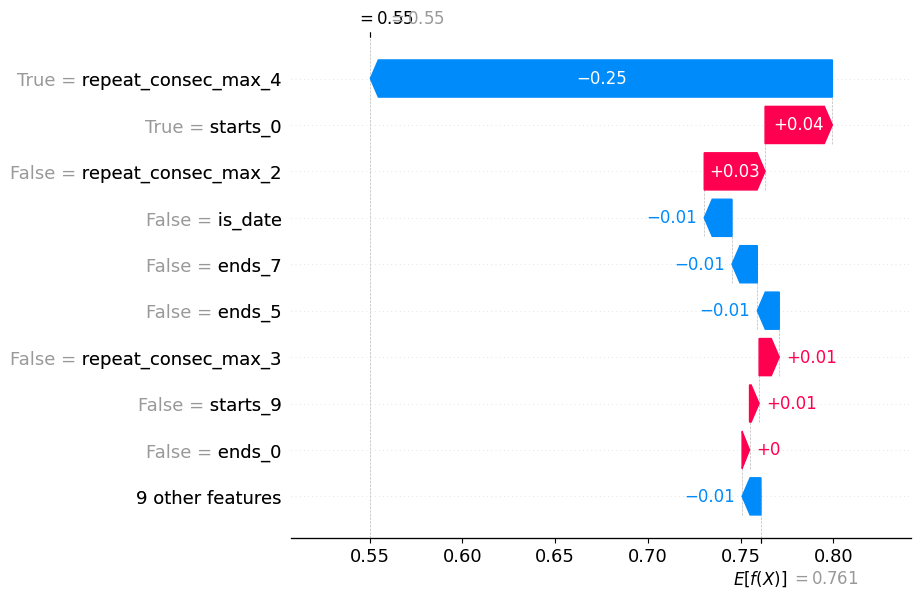

In [36]:
shap.plots.waterfall(shap_values[2])
